In [2]:
import sys
sys.path.append("../../scripts/")
import json

import pandas

with open('../../data/Defects4J/all_d4j_crashes.txt') as f:
    jcrashpack_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

with open('../../data/Defects4J/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]


In [3]:

def evaluate(raw_result, only_crash=False):
    rows = []
    
    for bug_id, test_exec_results in raw_result.items():
        if bug_id in invalid_bugs:
            continue
        if only_crash and bug_id not in jcrashpack_bugs:
            continue
            
        for i, (fname, res) in enumerate(test_exec_results.items()):
            javalang_parse_error = False
            is_compile_error = False
            is_runtime_error = False
            buggy_version_failing = False
            fixed_version_failing = False
            success = False

            if isinstance(res, str):
                javalang_parse_error = True 
            elif res['buggy']['compile_error'] or res['fixed']['compile_error']:
                is_compile_error = True
            elif res['buggy']['runtime_error'] or res['fixed']['runtime_error']:
                is_runtime_error = True
            else:
                if res['buggy']['autogen_failed']:
                    buggy_version_failing = True
                if res['fixed']['autogen_failed']:
                    fixed_version_failing = True
                if buggy_version_failing and (not fixed_version_failing):
                    success = True
            
            rows.append({
                'project': bug_id.split('_')[0],
                'bug_id': bug_id,
                'test_no': i+1,
                'javalang_parse_error': javalang_parse_error,
                'is_compile_error': is_compile_error,
                'is_runtime_error': is_runtime_error,
                'buggy_version_failing': buggy_version_failing,
                'fixed_version_failing': fixed_version_failing,
                'fname': fname,
                'success': success,
            })
    
    return pandas.DataFrame(rows)

In [4]:
RESULT_PATH = '../../results/example2_n50.json'

with open(RESULT_PATH) as f:
    reproduction_df = evaluate(json.load(f))

aggr_eval_df = reproduction_df.groupby('bug_id').sum().reset_index()
aggr_eval_df['project'] = aggr_eval_df.bug_id.apply(lambda x: x.split('_')[0])
succeeded_bugs = aggr_eval_df[aggr_eval_df.success > 0]

#print all rows 
pandas.set_option('display.max_rows', None)

#sort by success
aggr_eval_df = aggr_eval_df.sort_values(by=['success'], ascending=False)

aggr_eval_df


/var/folders/02/v32fbxpj58lctc0_vvpsn9380000gn/T/ipykernel_11065/2706873750.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggr_eval_df = reproduction_df.groupby('bug_id').sum().reset_index()


,bug_id,test_no,javalang_parse_error,is_compile_error,is_runtime_error,buggy_version_failing,fixed_version_failing,success,project
510,Jsoup_74,1275,0,0,0,50,0,50,Jsoup
440,Jsoup_1,1275,1,0,0,47,1,47,Jsoup
375,JacksonDatabind_42,1275,0,3,0,46,0,46,JacksonDatabind
604,Lang_6,1275,0,2,0,47,1,46,Lang
607,Lang_62,1275,0,3,0,46,0,46,Lang
306,JacksonCore_12,1275,1,3,0,45,0,45,JacksonCore
734,Time_13,1275,0,1,0,46,3,44,Time
511,Jsoup_75,1275,0,2,0,47,4,44,Jsoup
578,Lang_36,1275,0,4,0,46,2,44,Lang
621,Math_105,1275,0,6,0,44,0,44,Math


In [5]:
with open(RESULT_PATH) as f:
    reproduction_df = evaluate(json.load(f))

aggr_eval_df = reproduction_df.groupby('bug_id').sum().reset_index()
aggr_eval_df['project'] = aggr_eval_df.bug_id.apply(lambda x: x.split('_')[0])
succeeded_bugs = aggr_eval_df[aggr_eval_df.success > 0]

total_succ = 0
total_bugs = 0
tab_results = []
for project in sorted(set(succeeded_bugs.project.tolist())):
    succeeded_bug_ids = succeeded_bugs[succeeded_bugs.project == project].bug_id.tolist()
    succ_num = len(succeeded_bug_ids)
    total_succ += succ_num
    total_num = (aggr_eval_df.project == project).sum()
    total_bugs += total_num
    tab_results.append({'Project': project, 'rep': succ_num, 'total': total_num})
tab_results.append({'Project': 'Total', 'rep': total_succ, 'total': total_bugs})

tab_df = pandas.DataFrame(tab_results)
tab_df


/var/folders/02/v32fbxpj58lctc0_vvpsn9380000gn/T/ipykernel_11065/2250952069.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggr_eval_df = reproduction_df.groupby('bug_id').sum().reset_index()


,Project,rep,total
0,Chart,5,7
1,Cli,14,29
2,Closure,2,172
3,Codec,10,18
4,Collections,1,4
5,Compress,4,46
6,Csv,6,16
7,Gson,7,11
8,JacksonCore,8,24
9,JacksonDatabind,30,107


In [6]:
# Print off some example bug reports

from bs4 import BeautifulSoup

most_successful_bugs = aggr_eval_df.tail(5)
least_successful_bugs = aggr_eval_df.tail(5)

bugs_to_print = aggr_eval_df[(aggr_eval_df['success'] > 10) & (aggr_eval_df['success'] < 40)].sample(n=10)


for bug_id in bugs_to_print.bug_id:
    bug_id = bug_id.replace('_', '-')
    with open(f'../../data/Defects4J/bug_report/{bug_id}.json', 'r') as f:
        bug_report = json.load(f)
        soup = BeautifulSoup(bug_report['description'], 'html.parser')
        description = soup.get_text()
        print (f"**Bug ID:** {bug_id}")
        print(f"**Issue ID:** {bug_report['issue_id']}")
        print(f"**Title:** {bug_report['title']}")
        print(f"**Description:** {description}")
        print("\n---\n")




**Bug ID:** Lang-27
**Issue ID:** LANG-638
**Title:** NumberUtils createNumber throws a StringIndexOutOfBoundsException when argument containing "e" and "E" is passed in
**Description:** 

NumberUtils createNumber throws a StringIndexOutOfBoundsException instead of NumberFormatException when a String containing both possible exponent indicators is passed in.
One example of such a String is "1eE".



---

**Bug ID:** Jsoup-21
**Issue ID:** 179
**Title:** Selector parsing gets confused by commata in regexes
**Description:** 
The selector div, li:matches([0-9,]+) causes a java.util.regex.PatternSyntaxException because  QueryParser (line 63) thinks that the comma inside the regex is a combinator and thus extracts , li:matches([0-9 as the second alternative.
Instead of scanning ahead with `chompTo(","), the parser needs to parse its way through the alternative until it reaches a comma or the end of a string. That way, commata in regular expressions will be correctly interpreted as part of t

/var/folders/02/v32fbxpj58lctc0_vvpsn9380000gn/T/ipykernel_11065/1165076710.py:13: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/02/v32fbxpj58lctc0_vvpsn9380000gn/T/ipykernel_11065/1165076710.py:13: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/02/v32fbxpj58lctc0_vvpsn9380000gn/T/ipykernel_11065/1165076710.py:13: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/02/v32fbxpj58lctc0_vvpsn9380000gn/T/ipykernel_11065/1165076710.py:13: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/02/v32fbxpj58lctc0_

Average word count for bugs with success = 0: 114.94188376753507
Average word count for bugs with success > 0: 92.11155378486056


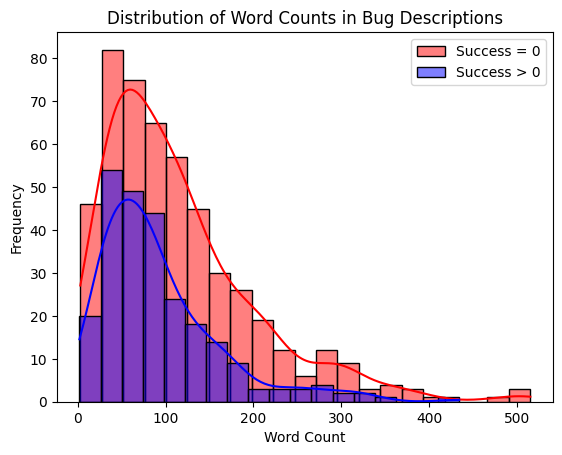

The correlation between word count and success is -0.12292878399789409 with a p-value of 0.0007415658881036888


In [34]:
# Get all data together in a single dataframe

new_df = pandas.DataFrame(columns=['project', 'bug_id', 'test_no', 'javalang_parse_error', 'is_compile_error', 'is_runtime_error', 'buggy_version_failing', 'fixed_version_failing', 'fname', 'success', 'title', 'description', 'issue_id'])

            
            
for index, row in aggr_eval_df.iterrows():
    bug_id = row['bug_id'].replace('_', '-')
    bug_report_path = f'../../data/Defects4J/bug_report/{bug_id}.json'
    if os.path.exists(bug_report_path):
        with open(bug_report_path, 'r') as f:
            bug_report = json.load(f)
            soup = BeautifulSoup(bug_report['description'], 'html.parser')
            description = soup.get_text()
            issue_id = bug_report['issue_id']
            title = bug_report['title']
            new_row = pandas.DataFrame([{'project': row['project'], 'bug_id': bug_id, 'test_no': row['test_no'], 'javalang_parse_error': row['javalang_parse_error'], 'is_compile_error': row['is_compile_error'], 'is_runtime_error': row['is_runtime_error'], 'buggy_version_failing': row['buggy_version_failing'], 'fixed_version_failing': row['fixed_version_failing'], 'success': row['success'], 'title': title, 'description': description, 'issue_id': issue_id}])
            new_df = pandas.concat([new_df, new_row], ignore_index=True)



# Look at difference in word count between successful and unsuccessful bugs

success_zero_df = new_df[new_df['success'] == 0]
success_non_zero_df = new_df[new_df['success'] > 0]

average_word_count_zero_success = success_zero_df['description'].apply(lambda x: len(x.split())).mean()
average_word_count_non_zero_success = success_non_zero_df['description'].apply(lambda x: len(x.split())).mean()

print(f"Average word count for bugs with success = 0: {average_word_count_zero_success}")
print(f"Average word count for bugs with success > 0: {average_word_count_non_zero_success}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for word count
new_df['word_count'] = new_df['description'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts for bugs with success = 0
sns.histplot(data=new_df[new_df['success'] == 0], x='word_count', color='red', label='Success = 0', kde=True)

# Plot the distribution of word counts for bugs with success > 0
sns.histplot(data=new_df[new_df['success'] > 0], x='word_count', color='blue', label='Success > 0', kde=True)

plt.legend()
plt.title('Distribution of Word Counts in Bug Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


# Does word count predict success?

from scipy.stats import pearsonr
correlation, p_value = pearsonr(new_df['word_count'], new_df['success'])

print(f"The correlation between word count and success is {correlation} with a p-value of {p_value}")





In [31]:
# Does the occurrance of "test" in the description have an effect on success?

new_df['has_test'] = new_df['description'].apply(lambda x: 'test' in x.lower())

# Calculate the proportion of bugs with 'test' in the description that have success > 0
success_with_test = new_df[(new_df['has_test'] == True) & (new_df['success'] > 0)].shape[0] / new_df[new_df['has_test'] == True].shape[0]

# Calculate the proportion of bugs without 'test' in the description that have success > 0
success_without_test = new_df[(new_df['has_test'] == False) & (new_df['success'] > 0)].shape[0] / new_df[new_df['has_test'] == False].shape[0]

print(f"Proportion of bugs with 'test' in the description that have success > 0: {success_with_test}")
print(f"Proportion of bugs without 'test' in the description that have success > 0: {success_without_test}")



Proportion of bugs with 'test' in the description that have success > 0: 0.34944237918215615
Proportion of bugs without 'test' in the description that have success > 0: 0.3264033264033264
